In [14]:
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import *
sc.stop()
from pyspark.sql import SQLContext
sc =SparkContext()
sqlContext = SQLContext(sc)
import pyspark.sql.functions as func
import sys
from pyspark.sql.functions import countDistinct

In [15]:
#reading in sticker type data
feature_data = sqlContext.read.parquet("gs://ds-url-catag/stick_statistics/derived_features/")


In [16]:
#convert pyspark to pandas dataframe
import pandas as pd
import pyarrow.parquet as pq
feature_data_df  = feature_data.toPandas()

In [17]:
#checking size of dataframe
print 'Size of the dataframe: {}'.format(feature_data_df.shape)

Size of the dataframe: (7495040, 9)


In [18]:
#logarithmic transformation of two different variables
import numpy as np
feature_data_df['log_noofdays']=np.log10(1+feature_data_df.numofdays)
feature_data_df['log_avg_con_days']=np.log10(1+feature_data_df.avg_con_days)
feature_data_df['log_sticker_packs_sent']=np.log10(1+feature_data_df.sticker_packs_sent)
feature_data_df['log_distinct_sticker_packs_sent']=np.log10(1+feature_data_df.distinct_sticker_packs_sent)
feature_data_df['log_sum_paid']=np.log10(1+feature_data_df.sum_paid)
feature_data_df['log_sum_free']=np.log10(1+feature_data_df.sum_free)
feature_data_df['log_sum_subs']=np.log10(1+feature_data_df.sum_subs)
feature_data_df['log_sum_discont']=np.log10(1+feature_data_df.sum_discont)


In [19]:
import numpy as np
rndperm = np.random.permutation(feature_data_df.shape[0])

In [20]:
#computing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(feature_data_df[['log_noofdays','log_avg_con_days','log_sticker_packs_sent','log_distinct_sticker_packs_sent','log_sum_paid','log_sum_free','log_sum_subs','log_sum_discont']].values)

feature_data_df['pca-one'] = pca_result[:,0]
feature_data_df['pca-two'] = pca_result[:,1] 
feature_data_df['pca-three'] = pca_result[:,2]


print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)


Explained variation per principal component: [ 0.84617291  0.06662387  0.05912116]


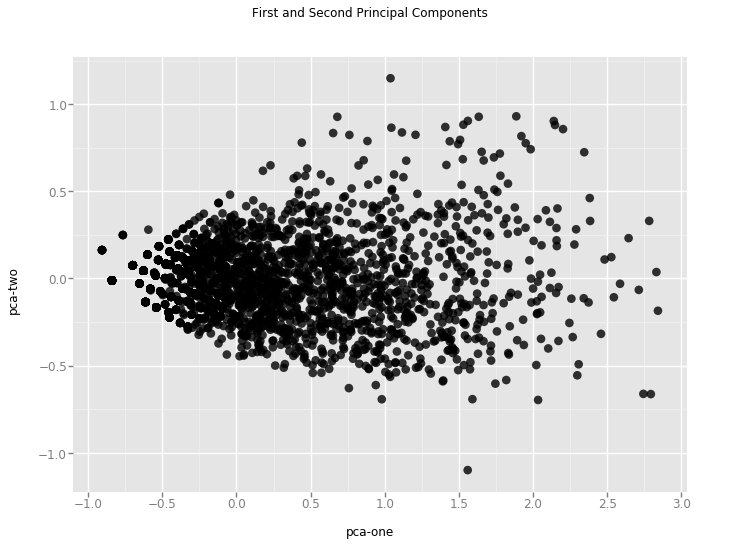

<ggplot: (8761872313669)>

In [96]:
from ggplot import *
chart = ggplot(feature_data_df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two',color = 'blue') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components")
chart

In [ ]:
#applying tsne
import time

from sklearn.manifold import TSNE

n_sne = 7495040

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature_data_df.loc[rndperm[:n_sne],['log_noofdays','log_avg_con_days','log_sticker_packs_sent','log_distinct_sticker_packs_sent','log_sum_paid','log_sum_free','log_sum_subs','log_sum_discont']].values)


print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing 121 nearest neighbors...


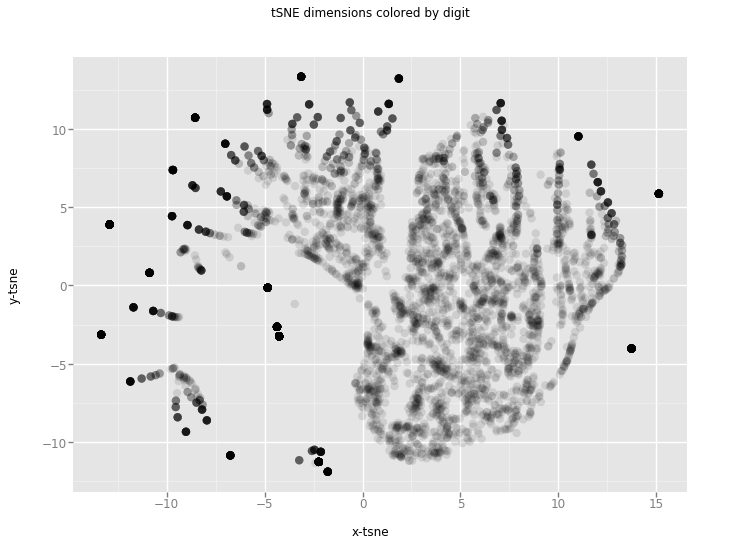

<ggplot: (8742599844845)>

In [21]:
from ggplot import *

df_tsne = feature_data_df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart




In [21]:
#clustering using Kmeans -PCA
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
model = kmeans.fit(feature_data_df[['pca-one','pca-two']])
y_kmeans = kmeans.predict(feature_data_df[['pca-one','pca-two']])

In [22]:
feature_data_df['clusters'] = kmeans.labels_

In [23]:
feature_data_df.columns

Index([u'user_id_n', u'numofdays', u'avg_con_days', u'sticker_packs_sent',
       u'distinct_sticker_packs_sent', u'sum_paid', u'sum_free', u'sum_subs',
       u'sum_discont', u'log_noofdays', u'log_avg_con_days',
       u'log_sticker_packs_sent', u'log_distinct_sticker_packs_sent',
       u'log_sum_paid', u'log_sum_free', u'log_sum_subs', u'log_sum_discont',
       u'pca-one', u'pca-two', u'pca-three', u'clusters'],
      dtype='object')

In [34]:
new_df = feature_data_df.as_matrix(columns=feature_data_df.columns[17:19])

In [38]:
new_df

array([[ 0.46263481, -0.42108124],
       [ 0.85693347, -0.02660164],
       [-0.27580967,  0.34648832],
       ..., 
       [-0.58066958, -0.06030877],
       [-0.30045551, -0.01857536],
       [-0.33523461,  0.17060807]])

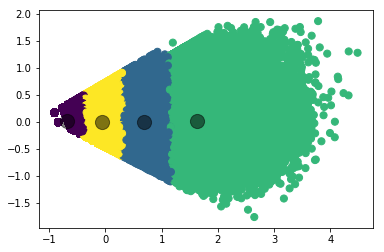

In [39]:
import matplotlib.pyplot as plt

centers = kmeans.cluster_centers_
plt.scatter(new_df[:, 0], new_df[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [41]:
df_tsne.columns[20:22]

Index([u'x-tsne', u'y-tsne'], dtype='object')

In [42]:
new_df_tsne = df_tsne.as_matrix(columns=df_tsne.columns[20:22])

In [43]:
#clustering using Kmeans
from sklearn.cluster import KMeans
kmeans_tsne = KMeans(n_clusters=4)
model_tsne = kmeans_tsne.fit(df_tsne[['x-tsne','y-tsne']])
y_kmeans_tsne = kmeans_tsne.predict(df_tsne[['x-tsne','y-tsne']])

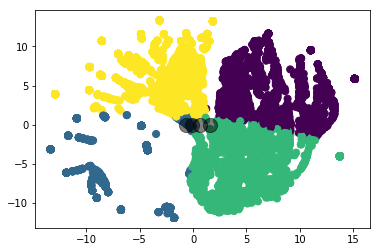

In [45]:
centers = kmeans.cluster_centers_
plt.scatter(new_df_tsne[:, 0], new_df_tsne[:, 1], c=y_kmeans_tsne, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [147]:
print new_df

[[ 0.46263481 -0.42108124]
 [ 0.85693347 -0.02660164]
 [-0.27580967  0.34648832]
 ..., 
 [-0.58066958 -0.06030877]
 [-0.30045551 -0.01857536]
 [-0.33523461  0.17060807]]


In [149]:
transformed = model.transform(feature_data_df[['pca-one','pca-two']])

In [ ]:
transformed.shape

In [ ]:
print transformed

In [ ]:
transformed.groupby('')